In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.compat import lzip

In [2]:
chill = pd.read_csv('data_csvs/everest_8000m_chill_time_series.csv')
chill.insert(loc=0, column='time', value=chill.index.to_numpy()*8)
chill.drop(columns=['local_time_of_forecast (Date Hour)'], inplace=True)

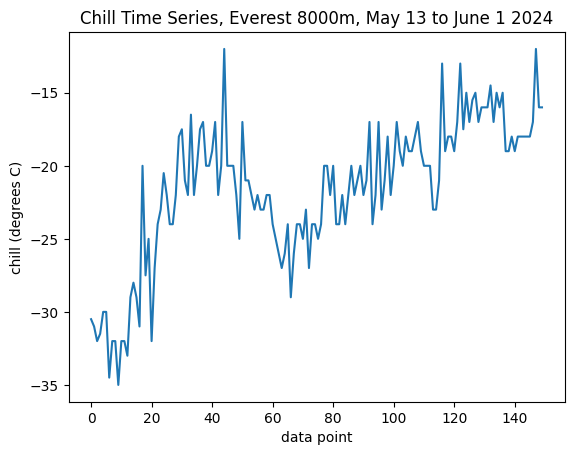

In [3]:
chill['chill'].plot()
plt.title('Chill Time Series, Everest 8000m, May 13 to June 1 2024')
plt.xlabel('data point')
plt.ylabel('chill (degrees C)')
plt.show()

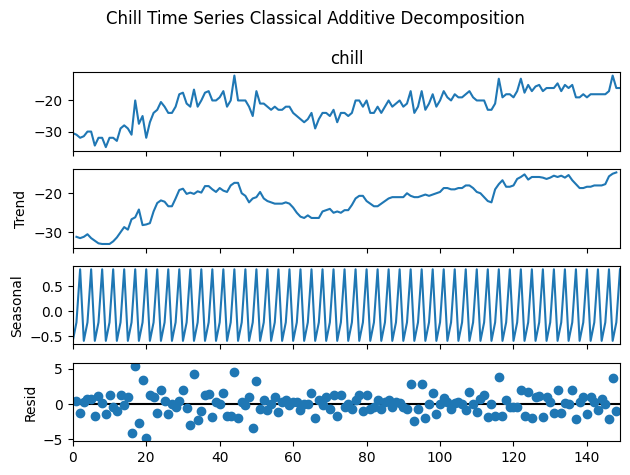

In [4]:
# Now we will attempt to decompose this time series into trend and seasonal components, using an additive model.
# I am intuitively setting the period to 3, since there are three data points per day
chill_decomp = seasonal_decompose(x=chill['chill'], period=3, model='additive')
chill_decomp.plot()
fig = plt.gcf()
fig.suptitle('Chill Time Series Classical Additive Decomposition')
fig.subplots_adjust(top=0.85)
plt.show()

In [5]:
# The trend is still not very smooth. However the residuals look like white noise to my eyes.

<AxesSubplot:title={'center':'Chill Time Series Decomp. Residuals'}, xlabel='data point', ylabel='residual'>

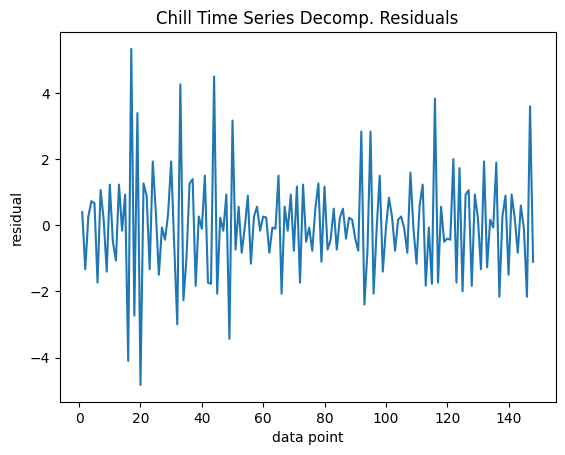

In [6]:
# To investigate the residuals of the decomposition, let's plot them separately.
chill_decomp_residuals = chill_decomp.resid[1:149]
plt.title('Chill Time Series Decomp. Residuals')
plt.xlabel('data point')
plt.ylabel('residual')
chill_decomp_residuals.plot()

In [7]:
# Looks kind of like white noise. I'm not sure whether the variance is constant, however.
# Breusch-Pagan test can shed light on this.
bp_df = chill_decomp_residuals.to_frame()
print('Mean of the residuals: ' + str(bp_df.mean(axis=0)) + '\n')
bp_df.insert(loc=0, column='index', value=bp_df.index.to_numpy())
bp_fit = smf.ols('resid ~ index', data=bp_df).fit()
print(bp_fit.summary())

names = ['Lagrange multiplier statistic', 'p-value', 'f-value', 'f p-value']
bp_result = sms.het_breuschpagan(bp_fit.resid, bp_fit.model.exog)
lzip(names, bp_result)

Mean of the residuals: resid    0.000431
dtype: float64

                            OLS Regression Results                            
Dep. Variable:                  resid   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.007
Method:                 Least Squares   F-statistic:                  0.004055
Date:                Thu, 08 Aug 2024   Prob (F-statistic):              0.949
Time:                        15:08:21   Log-Likelihood:                -276.57
No. Observations:                 148   AIC:                             557.1
Df Residuals:                     146   BIC:                             563.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------

[('Lagrange multiplier statistic', 3.624212130943643),
 ('p-value', 0.05694452839868035),
 ('f-value', 3.664984128763177),
 ('f p-value', 0.05752333328205823)]

In [8]:
# Well we certainly get a flat linear model. Note that the R2 value is 0.0, indicating the model is just a flat line, or it does no better than a flat line, which is what we expect.
# The Breusch-Pagan test is just above the critical value of 0.05, so we would retain the null hypothesis of homoscedasticity.

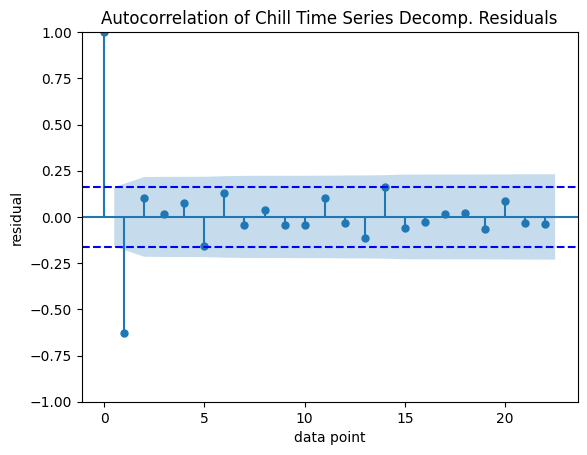

In [9]:
# Now, let's investigate the autocorrelations of the residuals.
plot_acf(chill_decomp_residuals, alpha=0.05)
plt.axhline(y=0.161, color='b', linestyle='--')
plt.axhline(y=-0.161, color='b', linestyle='--')
plt.title('Autocorrelation of Chill Time Series Decomp. Residuals')
plt.xlabel('data point')
plt.ylabel('residual')
plt.show()

In [10]:
# The autocorrelations seem to be essentially within the critical threshold, except for lag 1. 

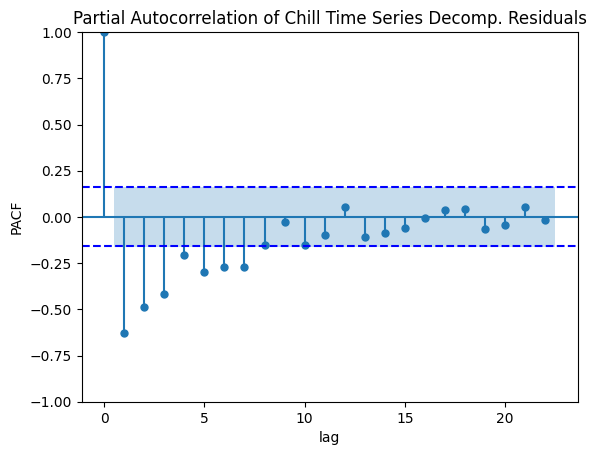

In [11]:
plot_pacf(chill_decomp_residuals, alpha=0.05)
plt.axhline(y=0.16, color='b', linestyle='--')
plt.axhline(y=-0.16, color='b', linestyle='--')
plt.title('Partial Autocorrelation of Chill Time Series Decomp. Residuals')
plt.xlabel('lag')
plt.ylabel('PACF')
plt.show()

In [12]:
# Interestingly, now we see tailing-off behavior in the partial autocorrelations.
# Taken with the ACF plot, these suggest an MA process with q = 1 or 5.

In [13]:
# Let's do a Ljung-Box test on the residuals to see what it has to say about the degree of autocorrelation.
acorr_ljungbox(chill_decomp_residuals)

,lb_stat,lb_pvalue
1,59.651977,1.132055e-14
2,61.220049,5.084349e-14
3,61.263399,3.157080e-13
4,62.131437,1.033643e-12
5,65.854395,7.451191e-13
6,68.433924,8.562211e-13
7,68.730419,2.666245e-12
8,68.968923,7.881429e-12
9,69.268287,2.118394e-11
10,69.553647,5.406576e-11


In [14]:
# Well, that indicates that there is still autocorrelation pretty much for sure.
# Since lag 1 displays a large (in terms of absolute value) autocorrelation, this probably dominates the values for all other lags of the test.

# Therefore, these results suggest that after the Classical Additive Decomposition there is still some information in the residuals.
# In particular, an AR(1) model is suggested.

In [15]:
wind = pd.read_csv('data_csvs/everest_8000m_wind_time_series.csv')
wind.insert(loc=0, column='time', value=wind.index.to_numpy()*8)
wind.drop(columns=['local_time_of_forecast (Date Hour)'], inplace=True)

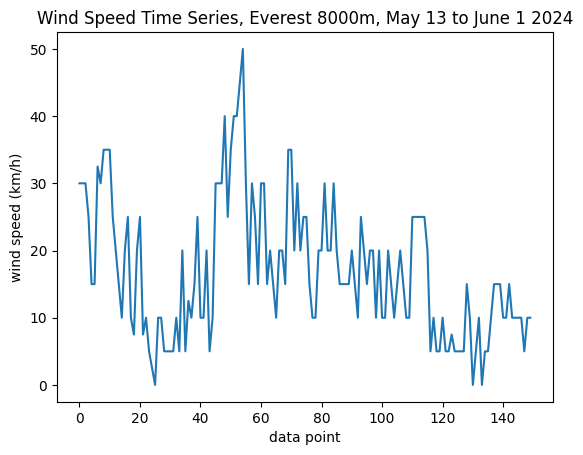

In [16]:
wind['wind_speed'].plot()
plt.title('Wind Speed Time Series, Everest 8000m, May 13 to June 1 2024')
plt.xlabel('data point')
plt.ylabel('wind speed (km/h)')
plt.show()

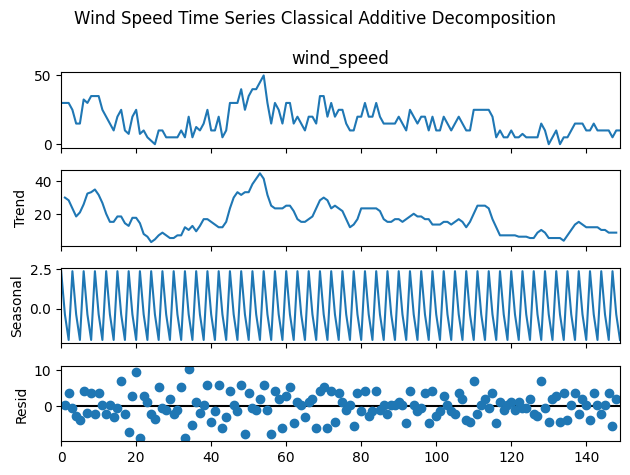

In [17]:
# Now we will attempt to decompose this time series into trend and seasonal components, using an additive model.
wind_decomp = seasonal_decompose(x=wind['wind_speed'], period=3, model='additive')
wind_decomp.plot()
fig = plt.gcf()
fig.suptitle('Wind Speed Time Series Classical Additive Decomposition')
fig.subplots_adjust(top=0.85)
plt.show()

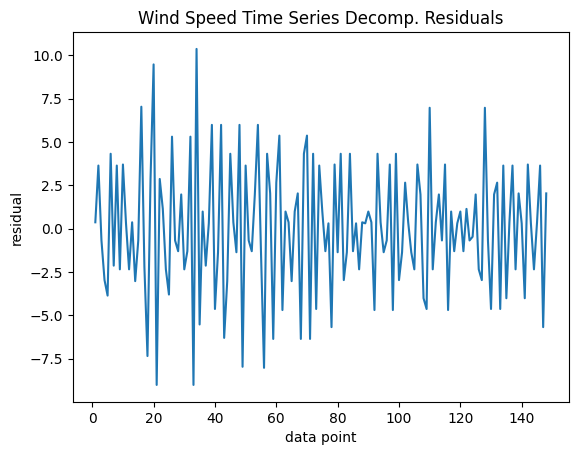

In [18]:
wind_decomp_residuals = wind_decomp.resid[1:149]
plt.title('Wind Speed Time Series Decomp. Residuals')
plt.xlabel('data point')
plt.ylabel('residual')
wind_decomp_residuals.plot()
plt.show()

In [19]:
# The variance seems to decrease as well in this case.
bp_df = wind_decomp_residuals.to_frame()
print('Mean of the residuals: ' + str(bp_df.mean(axis=0)) + '\n')
bp_df.insert(loc=0, column='index', value=bp_df.index.to_numpy())
bp_fit = smf.ols('resid ~ index', data=bp_df).fit()
print(bp_fit.summary())

names = ['Lagrange multiplier statistic', 'p-value', 'f-value', 'f p-value']
bp_result = sms.het_breuschpagan(bp_fit.resid, bp_fit.model.exog)
lzip(names, bp_result)

Mean of the residuals: resid    0.002494
dtype: float64

                            OLS Regression Results                            
Dep. Variable:                  resid   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.007
Method:                 Least Squares   F-statistic:                  0.003306
Date:                Thu, 08 Aug 2024   Prob (F-statistic):              0.954
Time:                        15:08:22   Log-Likelihood:                -405.18
No. Observations:                 148   AIC:                             814.4
Df Residuals:                     146   BIC:                             820.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------

[('Lagrange multiplier statistic', 6.53595519131511),
 ('p-value', 0.010571544382669006),
 ('f-value', 6.745526463791753),
 ('f p-value', 0.010360262585934941)]

In [20]:
# Again, R2 of 0.0 and a flat model as expected.
# This time the p value actually falls short of 0.05, so we reject the null hypothesis. The residuals from this decomposition are heteroscedastic, apparently.

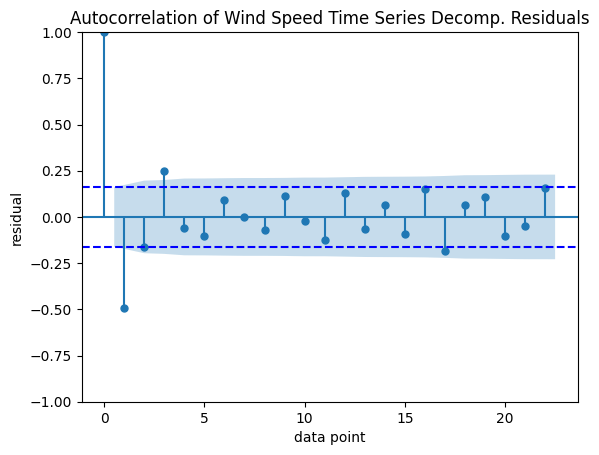

In [21]:
plot_acf(wind_decomp_residuals, alpha=0.05)
plt.axhline(y=0.161, color='b', linestyle='--')
plt.axhline(y=-0.161, color='b', linestyle='--')
plt.title('Autocorrelation of Wind Speed Time Series Decomp. Residuals')
plt.xlabel('data point')
plt.ylabel('residual')
plt.show()

In [22]:
# Like the chill data, there appears to be a strong autocorrelation at lag 1 for the residuals from the Classical Decomposition. 
# There also appears to be autocorrelation at lag 3.

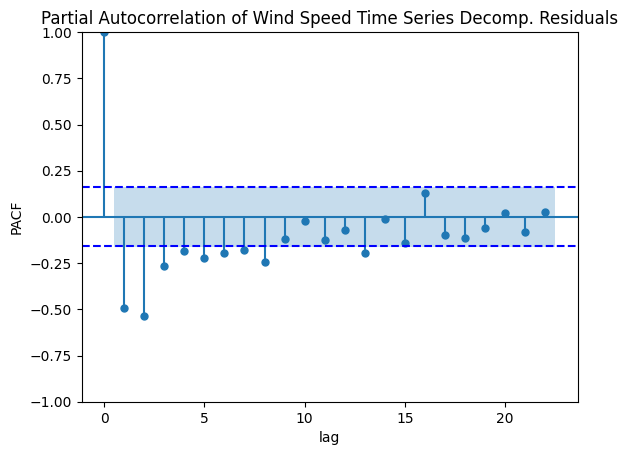

In [23]:
plot_pacf(wind_decomp_residuals, alpha=0.05)
plt.axhline(y=0.16, color='b', linestyle='--')
plt.axhline(y=-0.16, color='b', linestyle='--')
plt.title('Partial Autocorrelation of Wind Speed Time Series Decomp. Residuals')
plt.xlabel('lag')
plt.ylabel('PACF')
plt.show()

In [24]:
# Like with the chill decomp. residuals, there seems to be tailing-off from negative PACF values.
# These plots suggest an MA process with q = 3.

In [25]:
acorr_ljungbox(wind_decomp_residuals)

,lb_stat,lb_pvalue
1,36.779839,1.322509e-09
2,40.860497,1.340466e-09
3,50.138240,7.465528e-11
4,50.724997,2.547965e-10
5,52.354047,4.564022e-10
6,53.707758,8.449079e-10
7,53.707954,2.686385e-09
8,54.550934,5.397072e-09
9,56.673209,5.836301e-09
10,56.741920,1.490258e-08


In [26]:
# The Ljung-Box results are similar to those for the chill data series residuals, also indicating autocorrelation.
# Again, since the autocorrelation at lag 1 is so large, it dominates the behavior of the test out to greater lags.

# Therefore, these results suggest that after the Classical Additive Decomposition there is still some information in the residuals.
# In particular, an AR(3) model is suggested.